author : Gickel OKABI
mail : i.gickelokabi@gmail.com    

.

### Project : Mobile Price Classification

.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

.

In [2]:
#Set pandas to show all columns
pd.set_option('display.max_columns', None) # by defaut pandas displays 10 columns


.

In [3]:
#import train dataset
dataset = pd.read_csv("datasets/train.csv")
test_dataset = pd.read_csv("datasets/test.csv")

.

In [4]:
# show first 5 lines
dataset.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


.

In [5]:
# functoion to display the shape of the dataset as a graph

def datasetShape(dataset):

    plt.fill_between([dataset.shape[0]-1, dataset.shape[0]+1], [dataset.shape[1]-1, dataset.shape[1]-1], [dataset.shape[1]+1, dataset.shape[1]-1], color='lightblue')

    sns.scatterplot(x= dataset.shape[0], y=[ dataset.shape[1]], s=200)
    plt.text( dataset.shape[0]-0.1, dataset.shape[1]+0.1, f'row : {dataset.shape[0]} \n col : {dataset.shape[1]}')

    plt.xlabel("col")
    plt.ylabel("row")
    plt.plot()

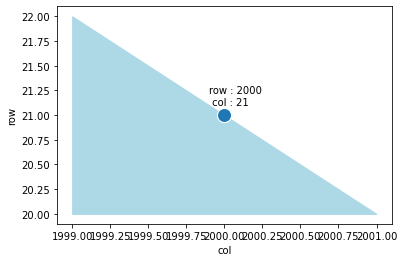

In [6]:
datasetShape(dataset)

.

In [7]:
# display the variables as well as the number of non-zero values

def dataset_variable(df):
    fig, ax = plt.subplots(figsize=(22, 6))
    sns.barplot(x=df.count().index, y= df.count().values)
    for i, v in enumerate(df.count().values):
        ax.annotate(str(v), xy=(i, v), xytext=(0, 3), textcoords="offset points", ha='center')

    plt.plot()

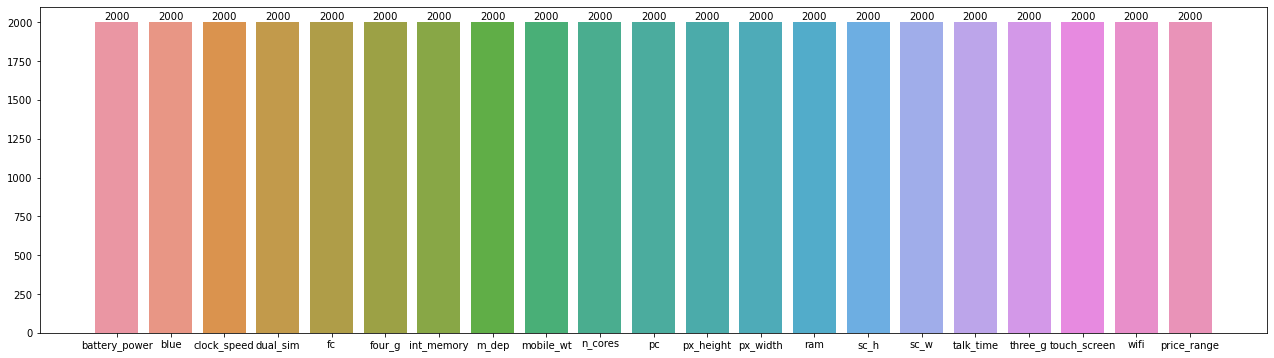

In [8]:
dataset_variable(dataset)

.

[]

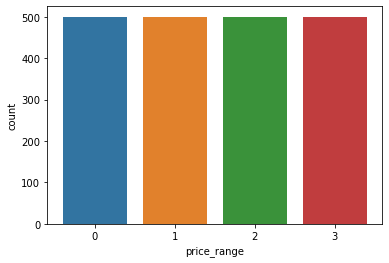

In [13]:
# Get the unique values and their frequencies
unique_values = dataset['price_range'].value_counts()

# Create the countplot to display the modalities and see if the dataset is balanced or not
sns.countplot(x='price_range', data=dataset)
plt.plot()

.

In [14]:
#show dataset info

def tabulate_func(dataset):

    summary_df = pd.DataFrame({
        "Variable Type": dataset.dtypes,
        "Missing Values": dataset.isna().sum(),
         "Total Values": dataset.count(),
        "unique values":  [dataset[column].unique().shape[0] for column in dataset.columns]

    })
    return summary_df

.

In [16]:
print(tabulate(tabulate_func(dataset), headers='keys', tablefmt='fancy_grid')) # display info in a formatted table

╒═══════════════╤═════════════════╤══════════════════╤════════════════╤═════════════════╕
│               │ Variable Type   │   Missing Values │   Total Values │   unique values │
╞═══════════════╪═════════════════╪══════════════════╪════════════════╪═════════════════╡
│ battery_power │ int64           │                0 │           2000 │            1094 │
├───────────────┼─────────────────┼──────────────────┼────────────────┼─────────────────┤
│ blue          │ int64           │                0 │           2000 │               2 │
├───────────────┼─────────────────┼──────────────────┼────────────────┼─────────────────┤
│ clock_speed   │ float64         │                0 │           2000 │              26 │
├───────────────┼─────────────────┼──────────────────┼────────────────┼─────────────────┤
│ dual_sim      │ int64           │                0 │           2000 │               2 │
├───────────────┼─────────────────┼──────────────────┼────────────────┼─────────────────┤
│ fc      

.

In [17]:
#display and examine the statistical description of the variables in the dataset
dataset.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


.

In [18]:
#Select the variables to analyze

variable_to_visual = [col for col in dataset.columns[:20]]

.

In [19]:
# This function will display 6 diagrams that will allow us to analyze the variables

def variable_visual(x_variable, y_variable):
    
    fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
    fig.suptitle(f"\n============Visualization and analysis of the variable============\n {x_variable}")
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for i in range(3):
        for j in range(2):
            sns.histplot(dataset[x_variable], kde=True, ax= axis[0,0])
            axis[0,0].set_title(x_variable +" "+ "Hitogram" )
            sns.boxplot(data=dataset, x=f'{x_variable}', y = f'{y_variable}',ax= axis[0,1])
            axis[0,1].set_title(x_variable +" "+ "boxplot" )
            sns.boxplot(data = dataset, x=f'{x_variable}', ax= axis[1,0])
            axis[1,0].set_title(x_variable +" "+ "Boxplot" )
            sns.violinplot(data = dataset, x=f'{x_variable}', ax= axis[1,1])
            axis[1,1].set_title(x_variable +" "+ "Violinplot" )
            sns.scatterplot(data = dataset, x=f'{x_variable}', y = f'{y_variable}', ax= axis[2,0])
            axis[2,0].set_title(x_variable +" "+ "scatter plot" )
            sns.lineplot(data = dataset, x=f'{x_variable}', y = f'{y_variable}', ax= axis[2,1])
            axis[2,1].set_title(x_variable +" "+ "lineplot" )
            
    plt.plot()        

.

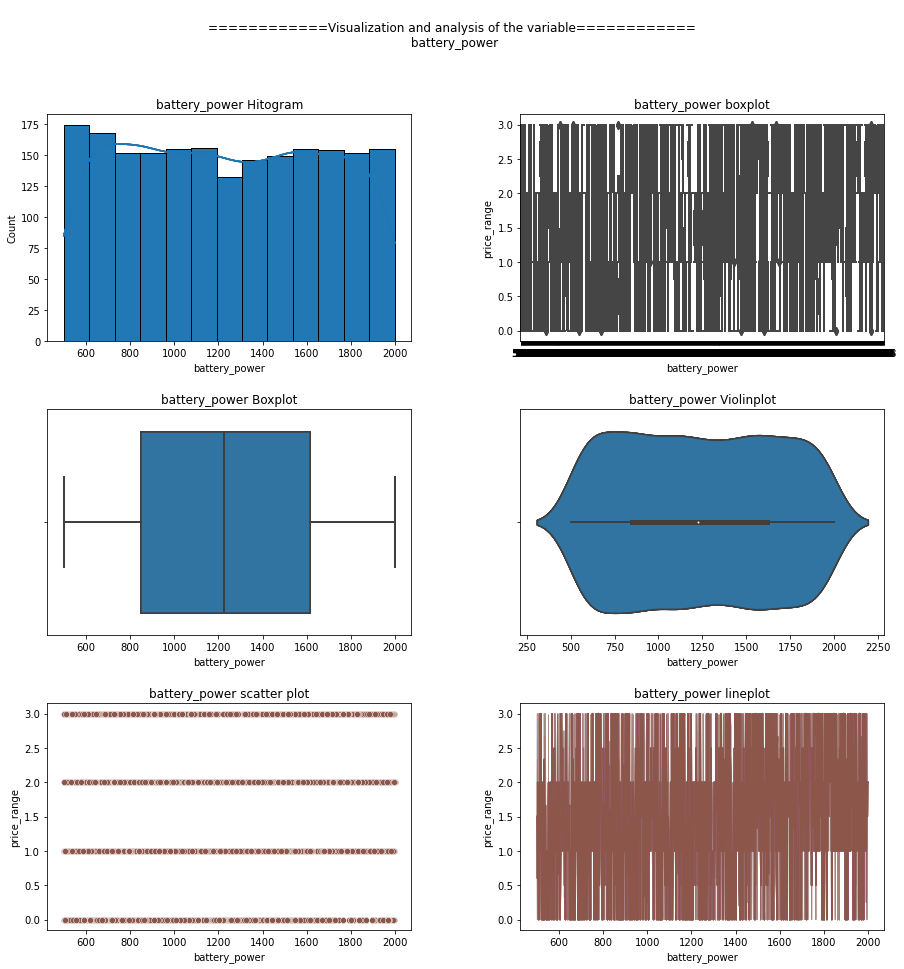

In [20]:
variable_visual(str(variable_to_visual[0]), 'price_range')

.

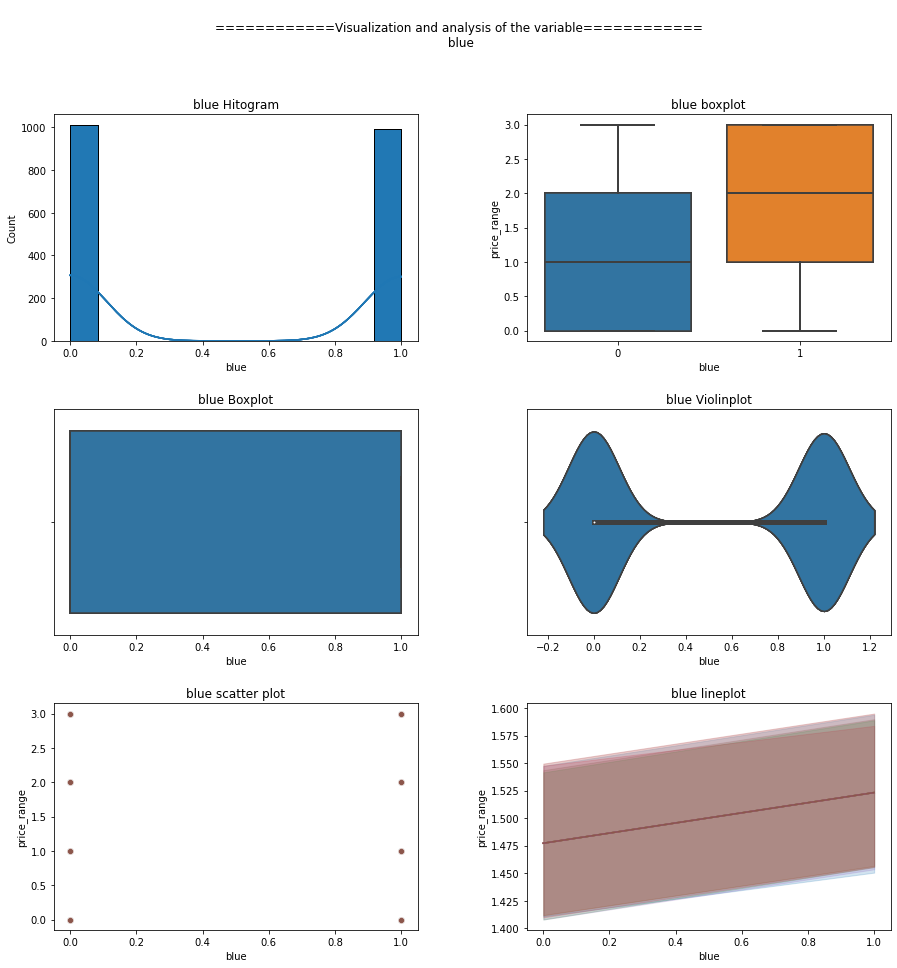

In [15]:
variable_visual(str(variable_to_visual[1]), 'price_range')

.

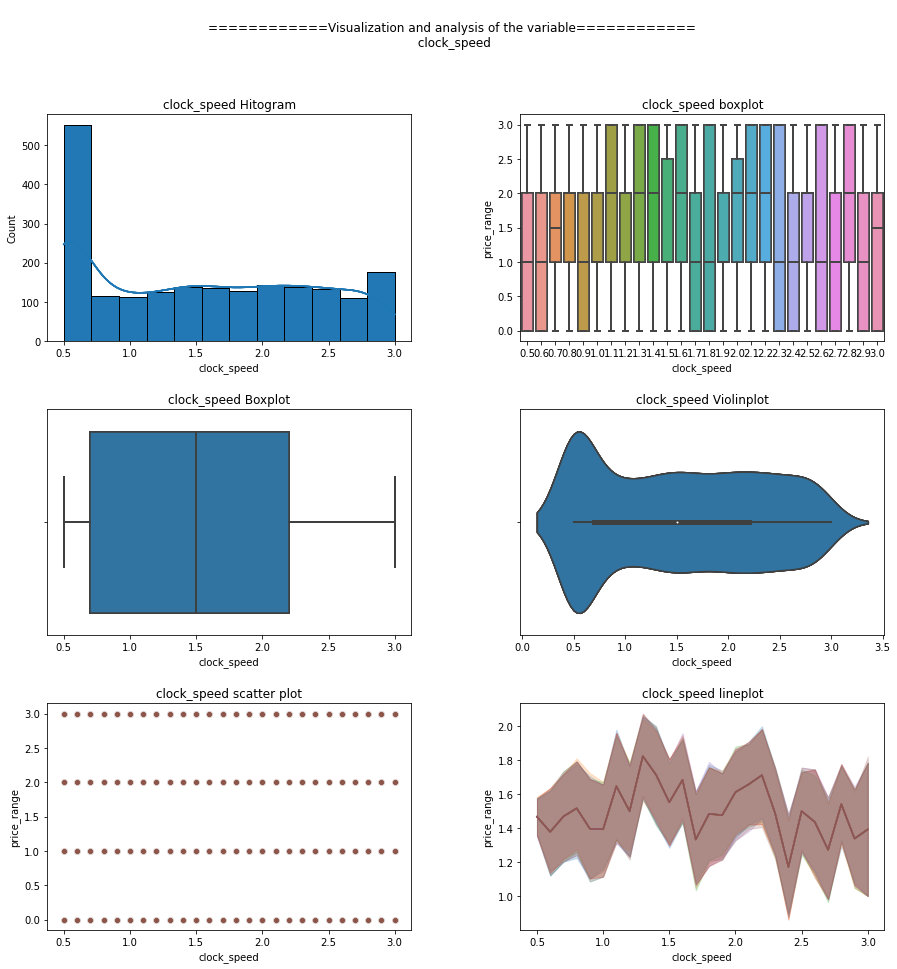

In [16]:
variable_visual(str(variable_to_visual[2]), 'price_range')

.

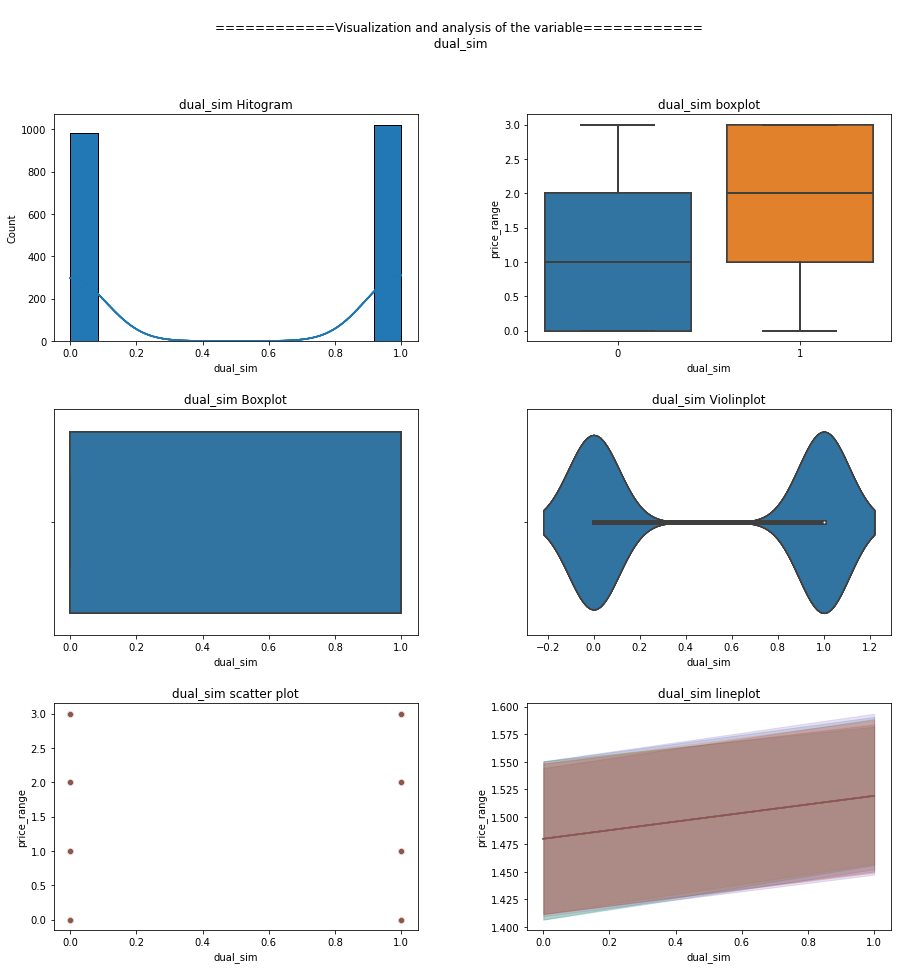

In [17]:
variable_visual(str(variable_to_visual[3]), 'price_range')

.

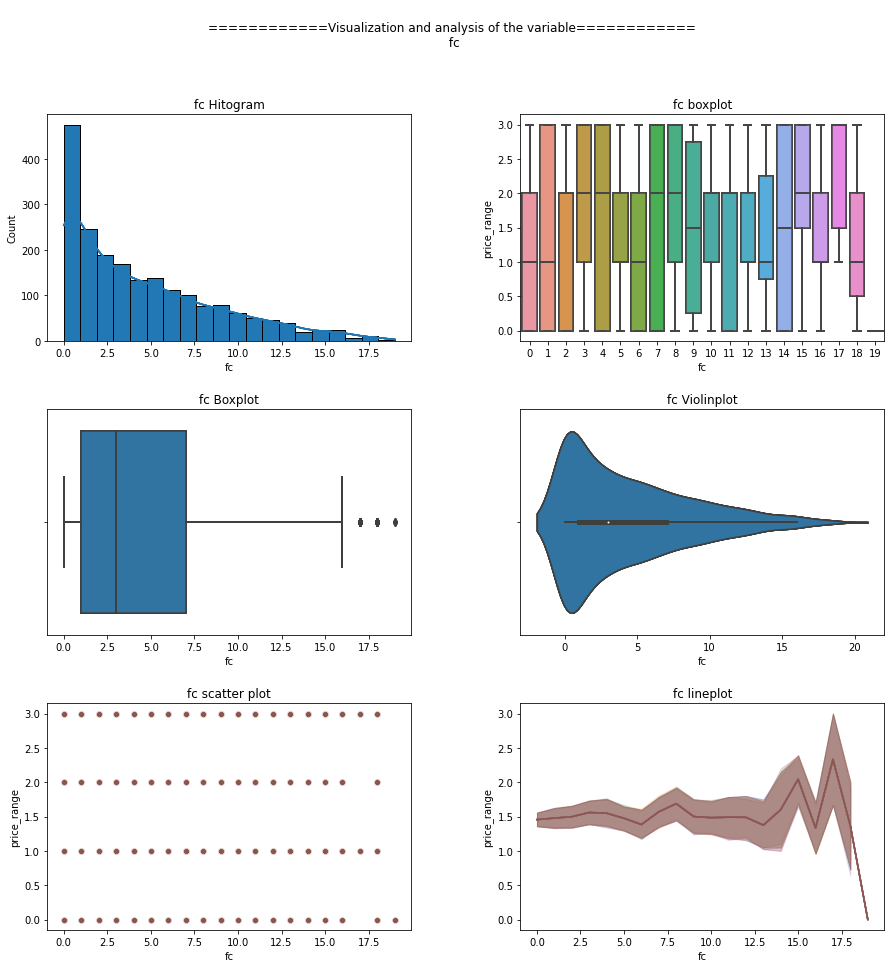

In [18]:
variable_visual(str(variable_to_visual[4]), 'price_range')

CCl : Variable (fc) with outliers

.

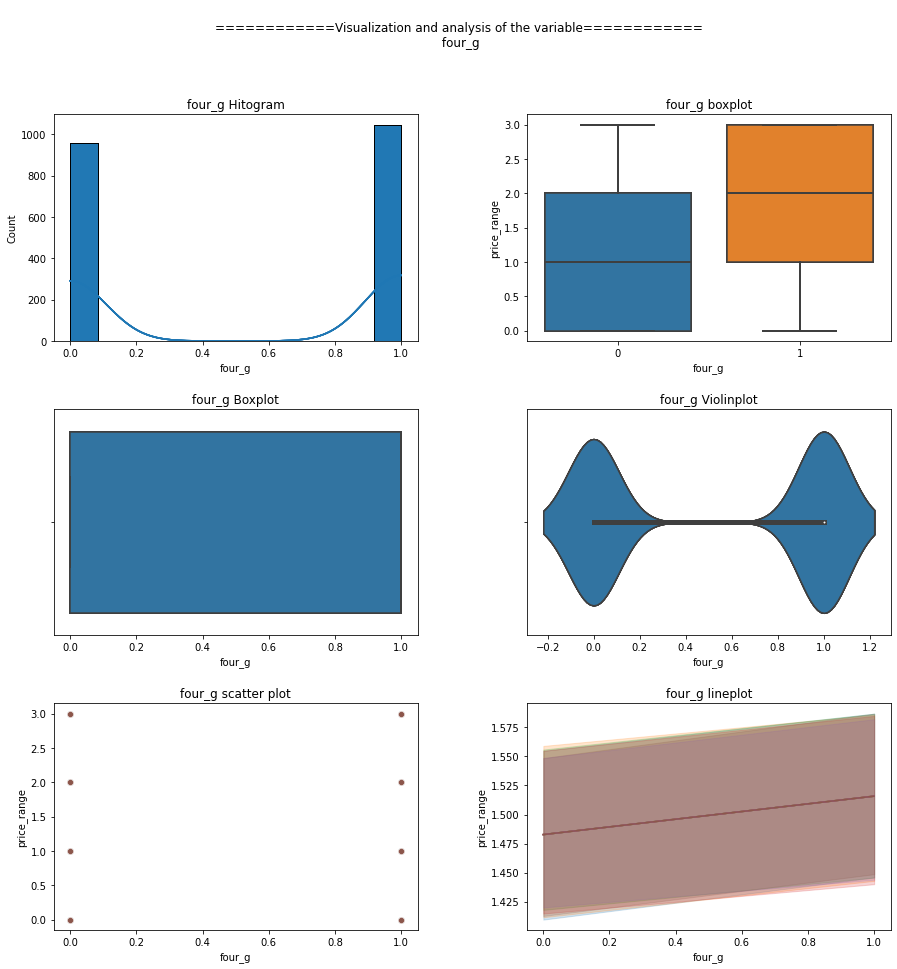

In [19]:
variable_visual(str(variable_to_visual[5]), 'price_range')

.

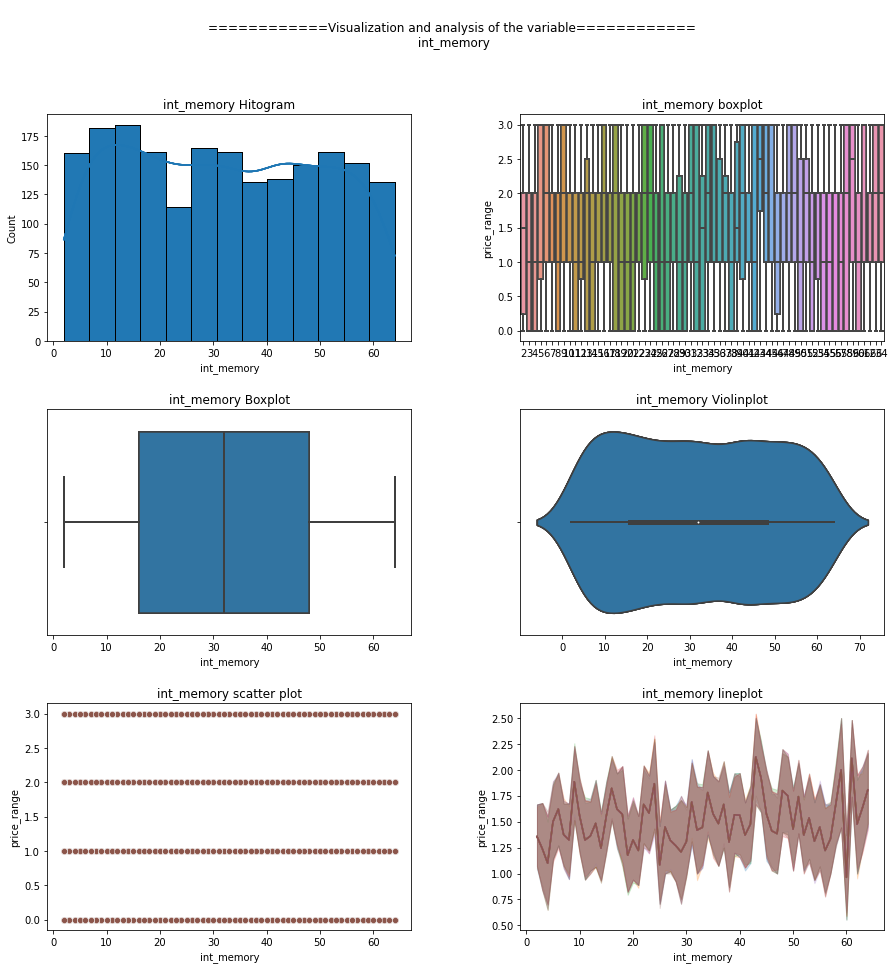

In [20]:
variable_visual(str(variable_to_visual[6]), 'price_range')

.

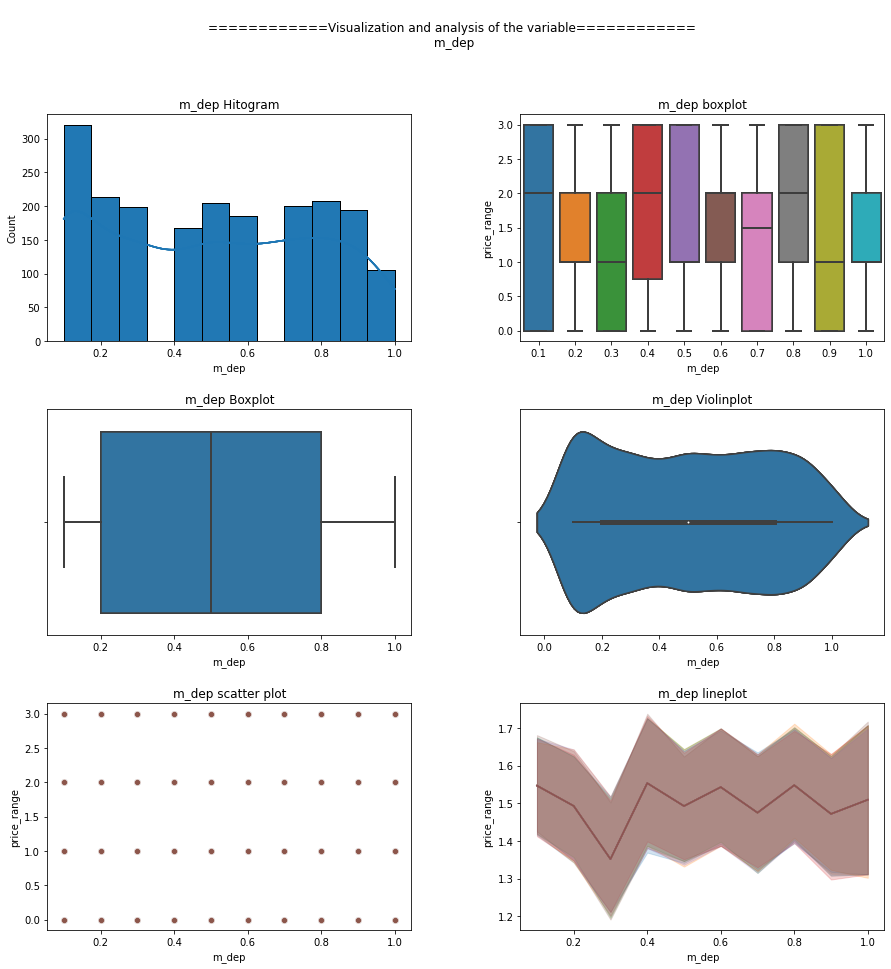

In [21]:
variable_visual(str(variable_to_visual[7]), 'price_range')

.

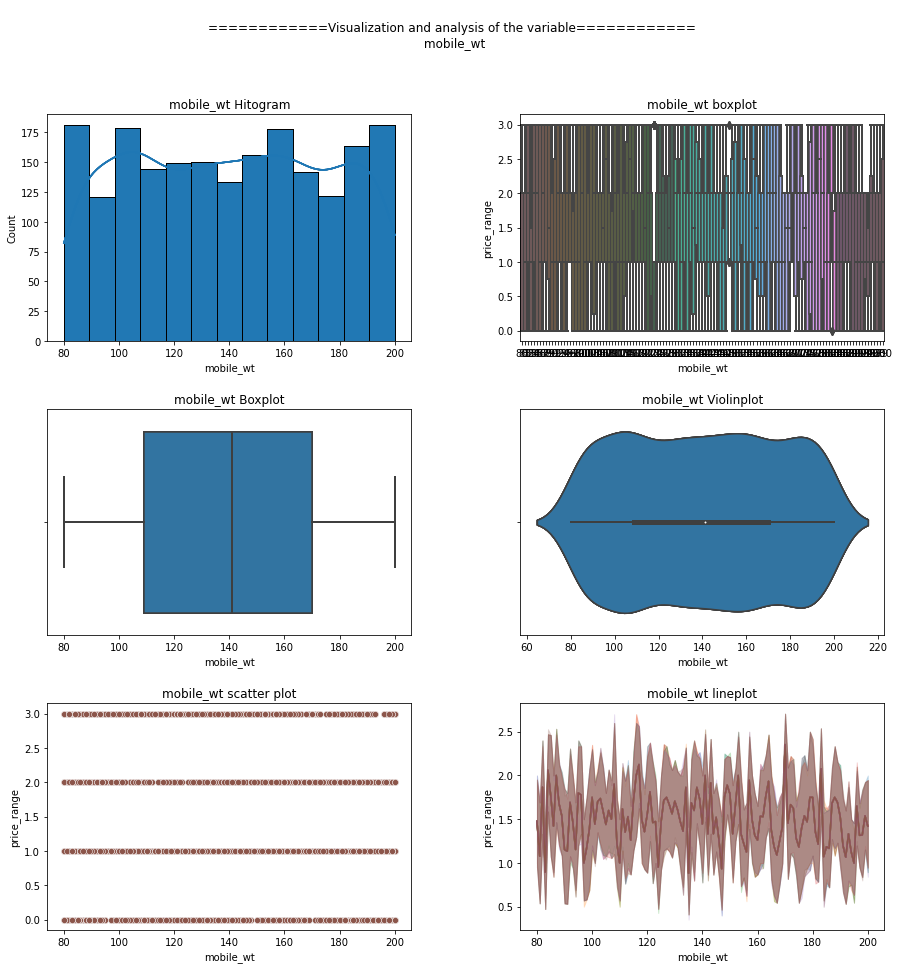

In [22]:
variable_visual(str(variable_to_visual[8]), 'price_range')

.

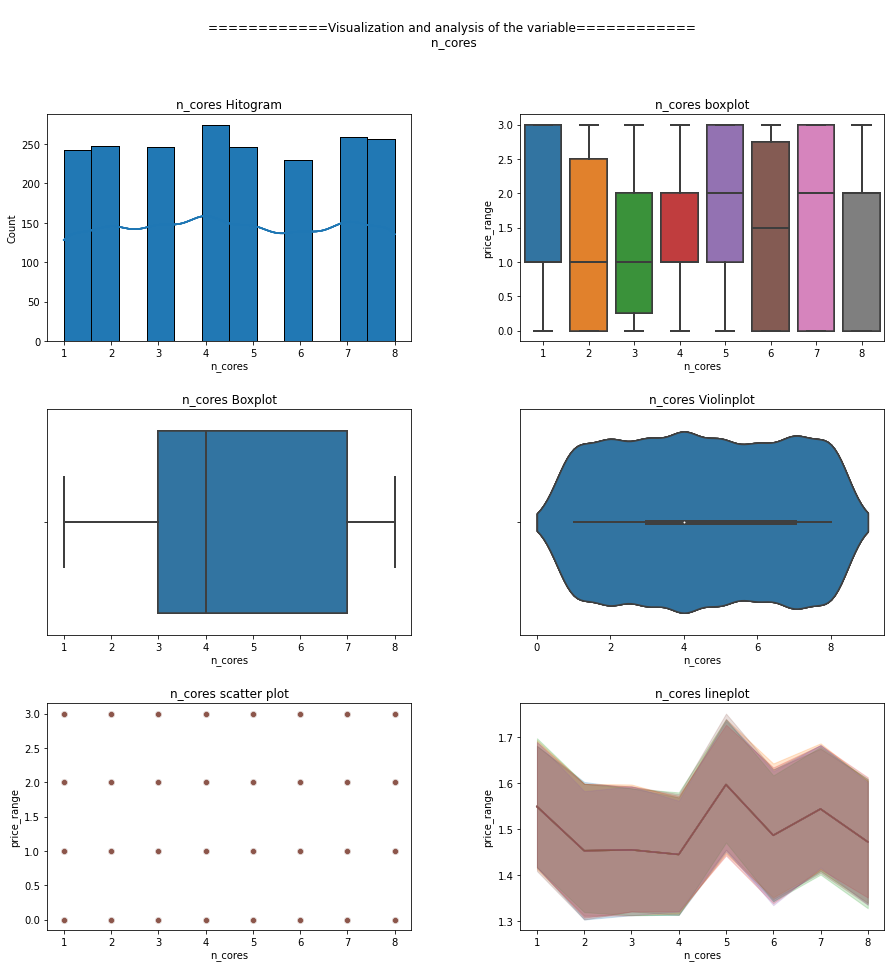

In [23]:
variable_visual(str(variable_to_visual[9]), 'price_range')

.

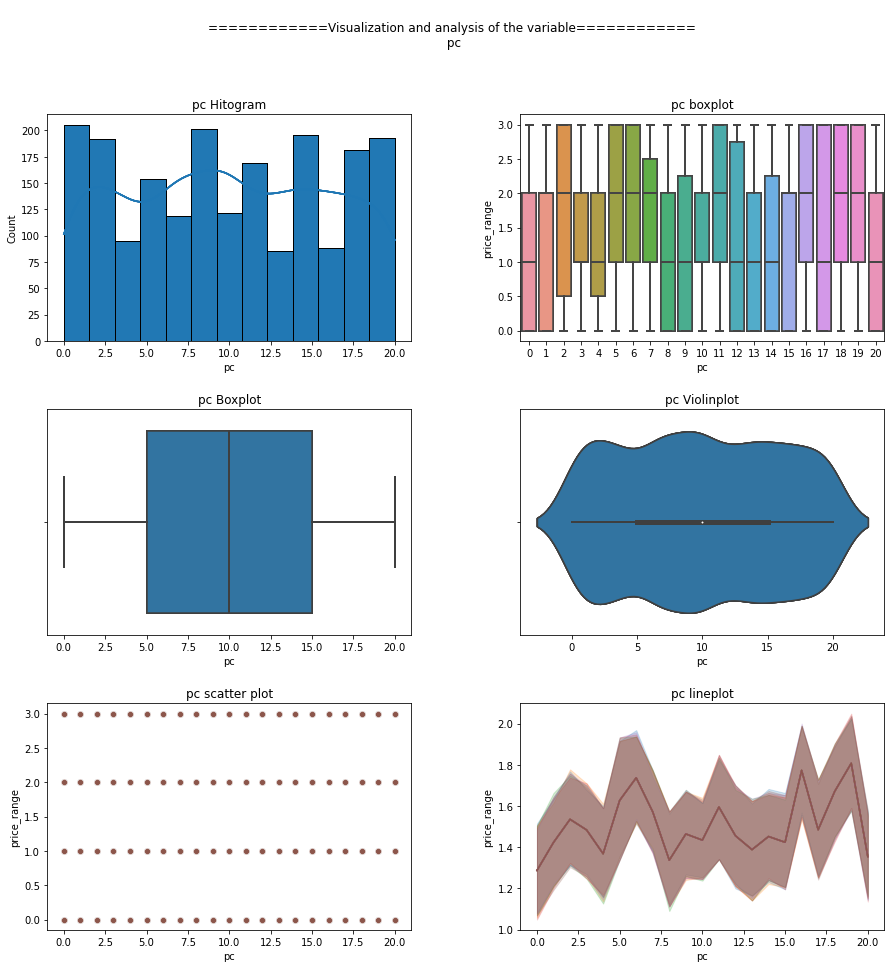

In [24]:
variable_visual(str(variable_to_visual[10]), 'price_range')

.

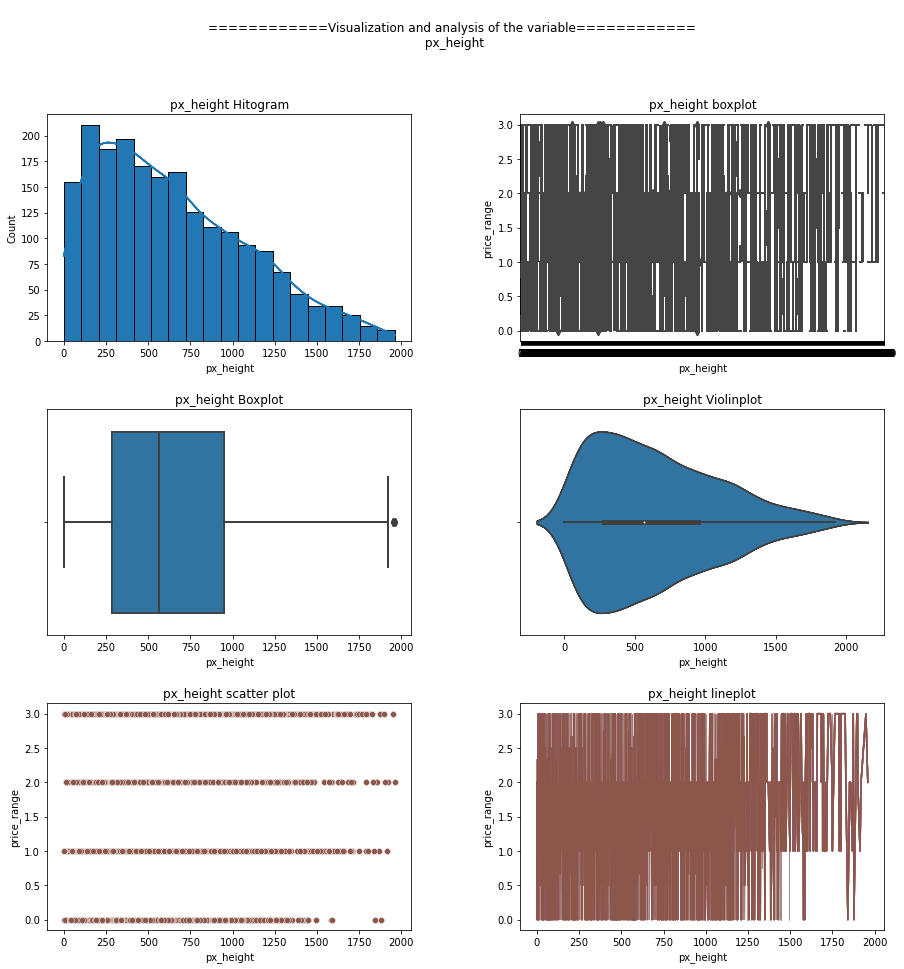

In [25]:
variable_visual(str(variable_to_visual[11]), 'price_range')

.

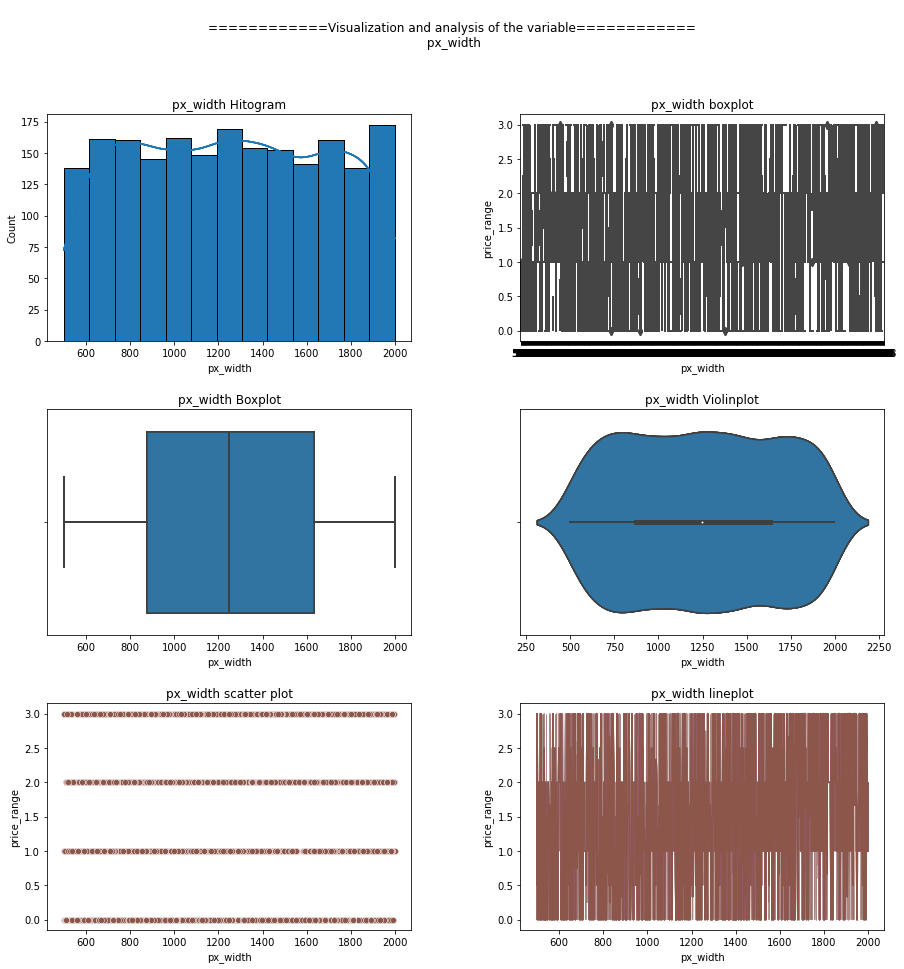

In [26]:
variable_visual(str(variable_to_visual[12]), 'price_range')

.

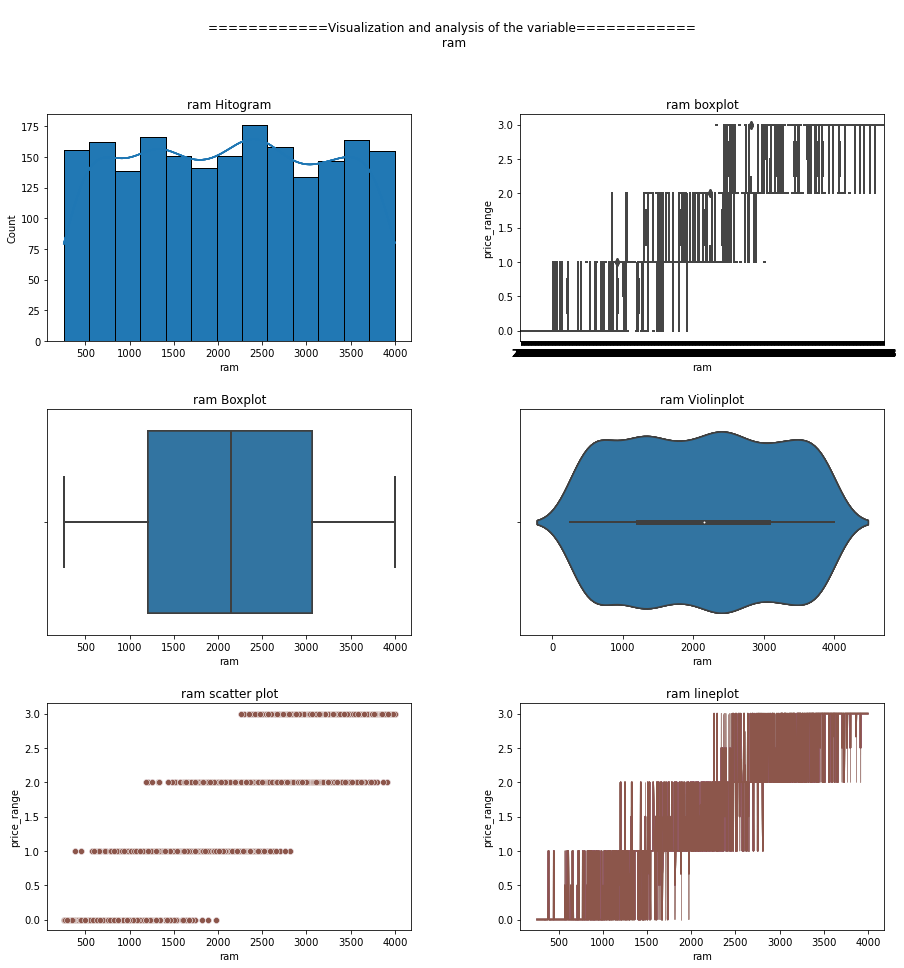

In [27]:
variable_visual(str(variable_to_visual[13]), 'price_range')

.

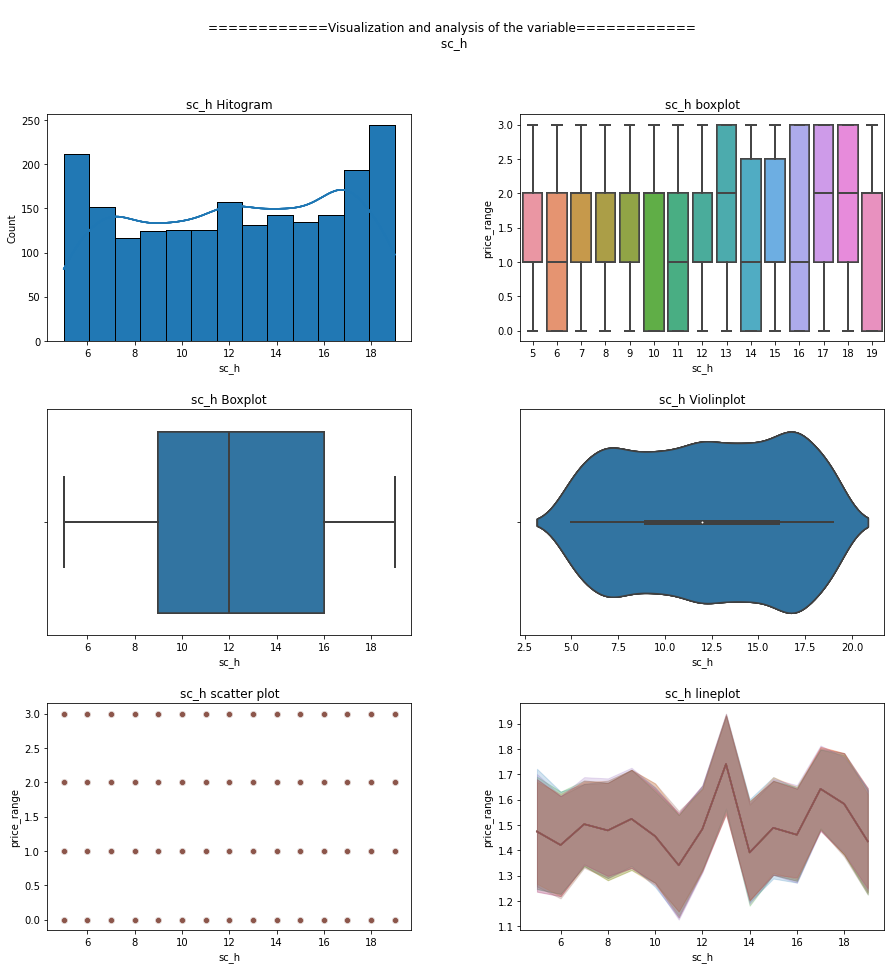

In [28]:
variable_visual(str(variable_to_visual[14]), 'price_range')

.

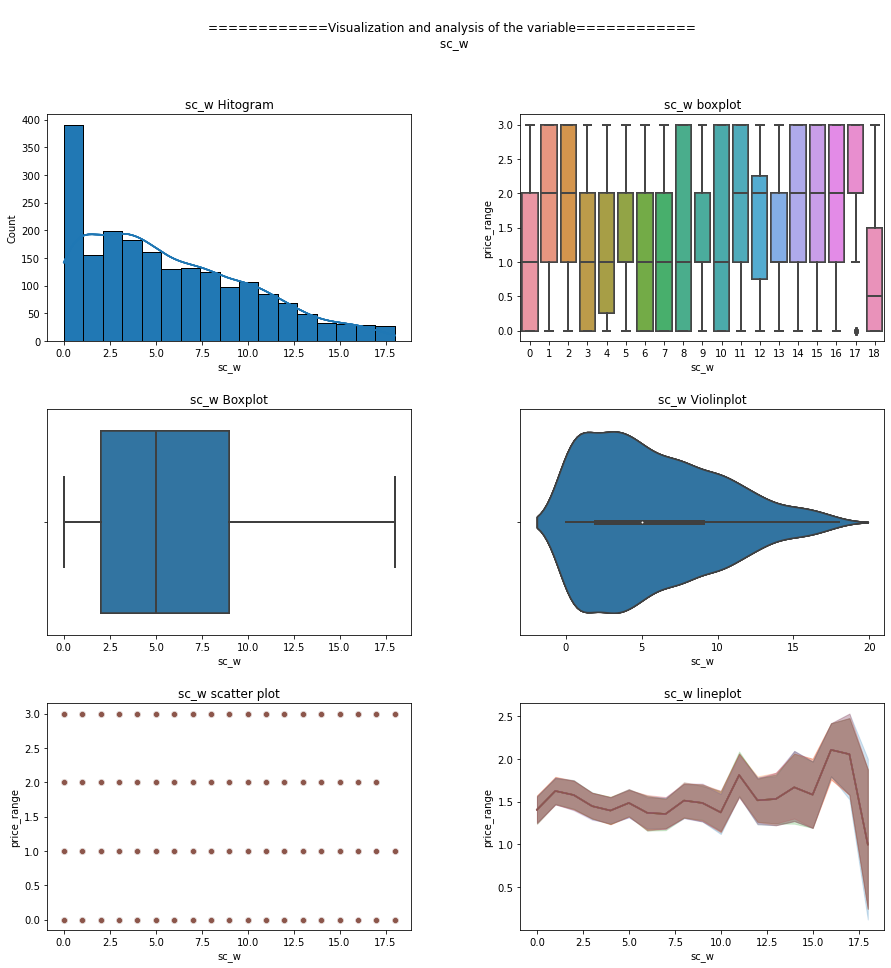

In [29]:
variable_visual(str(variable_to_visual[15]), 'price_range')

.

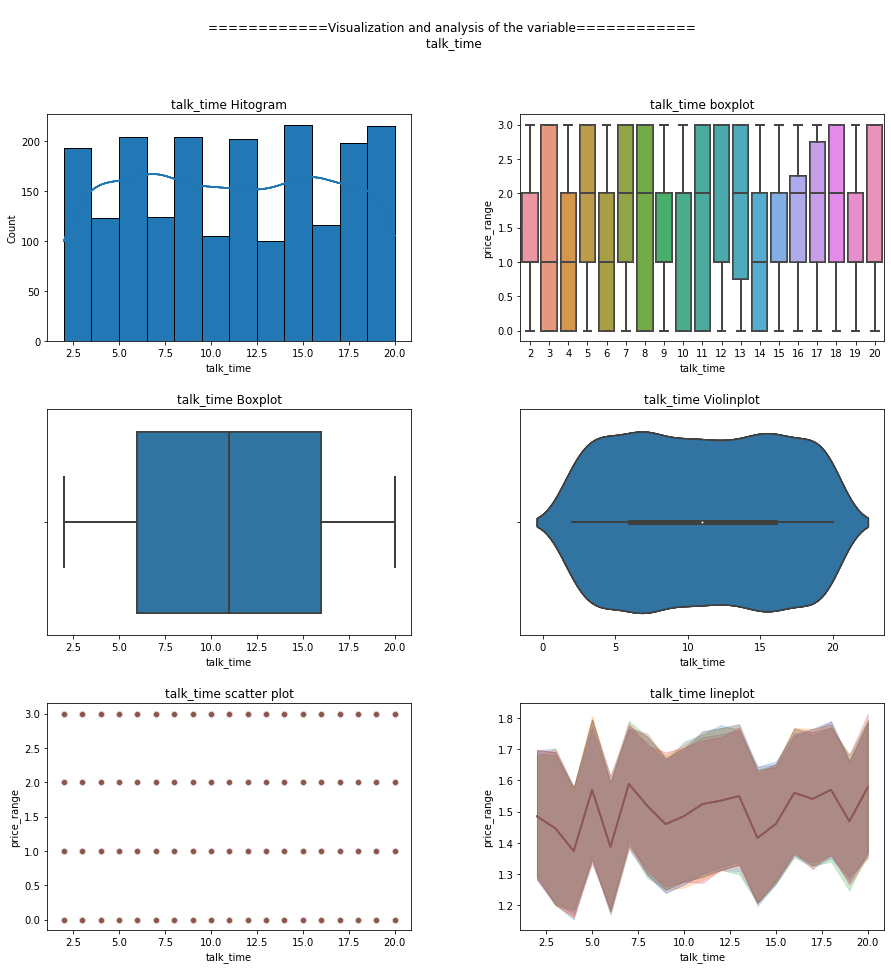

In [30]:
variable_visual(str(variable_to_visual[16]), 'price_range')

.

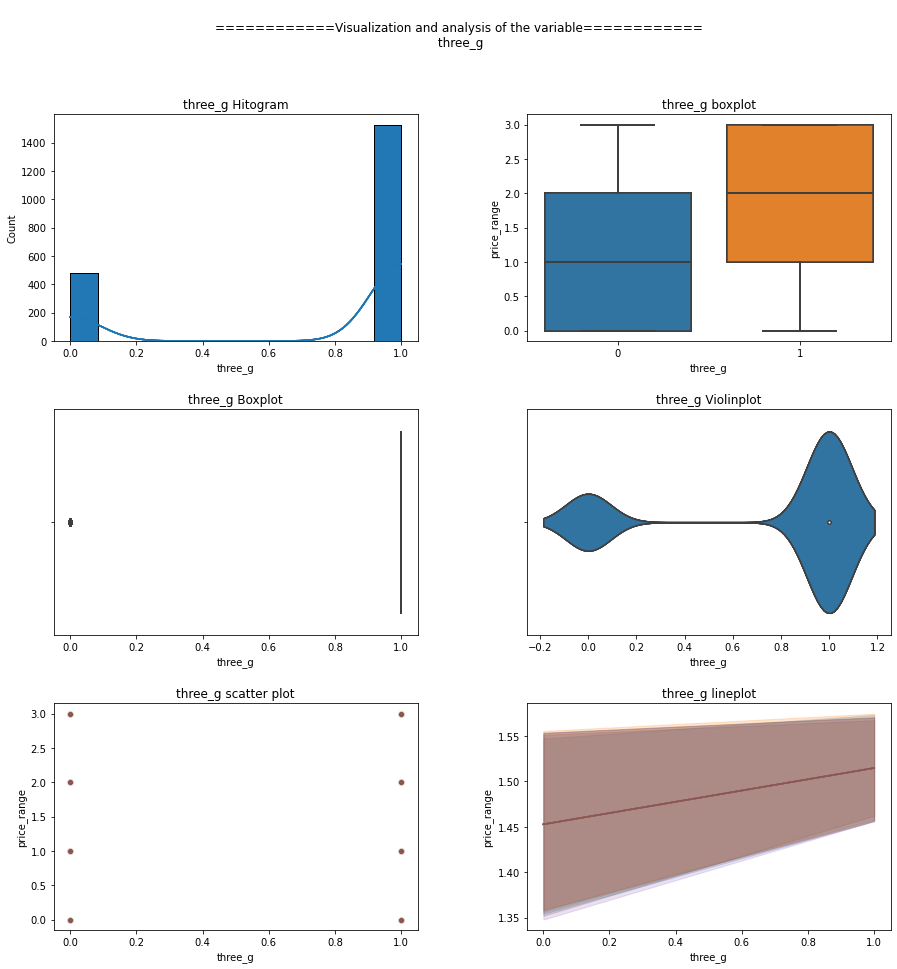

In [31]:
variable_visual(str(variable_to_visual[17]), 'price_range')

the boxplot shows us aberrant values, in reality it is the fact of an unbalanced variable(three_g) shown by the histogram

.

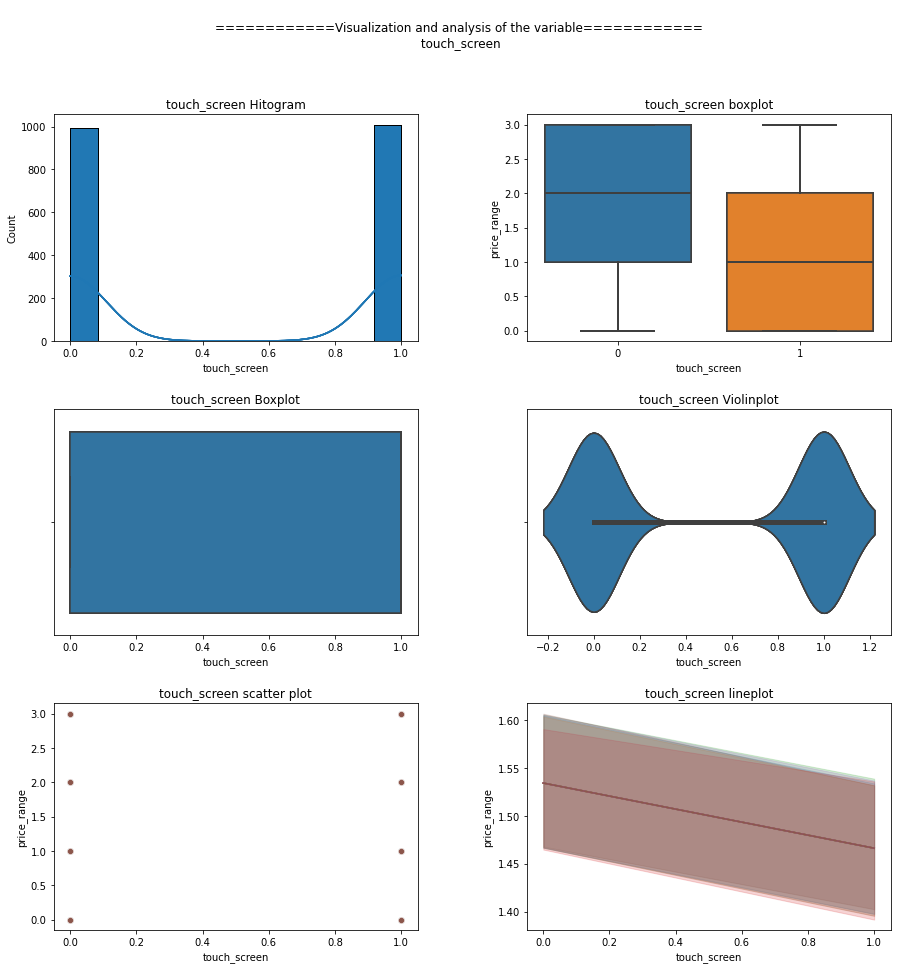

In [32]:
variable_visual(str(variable_to_visual[18]), 'price_range')

.

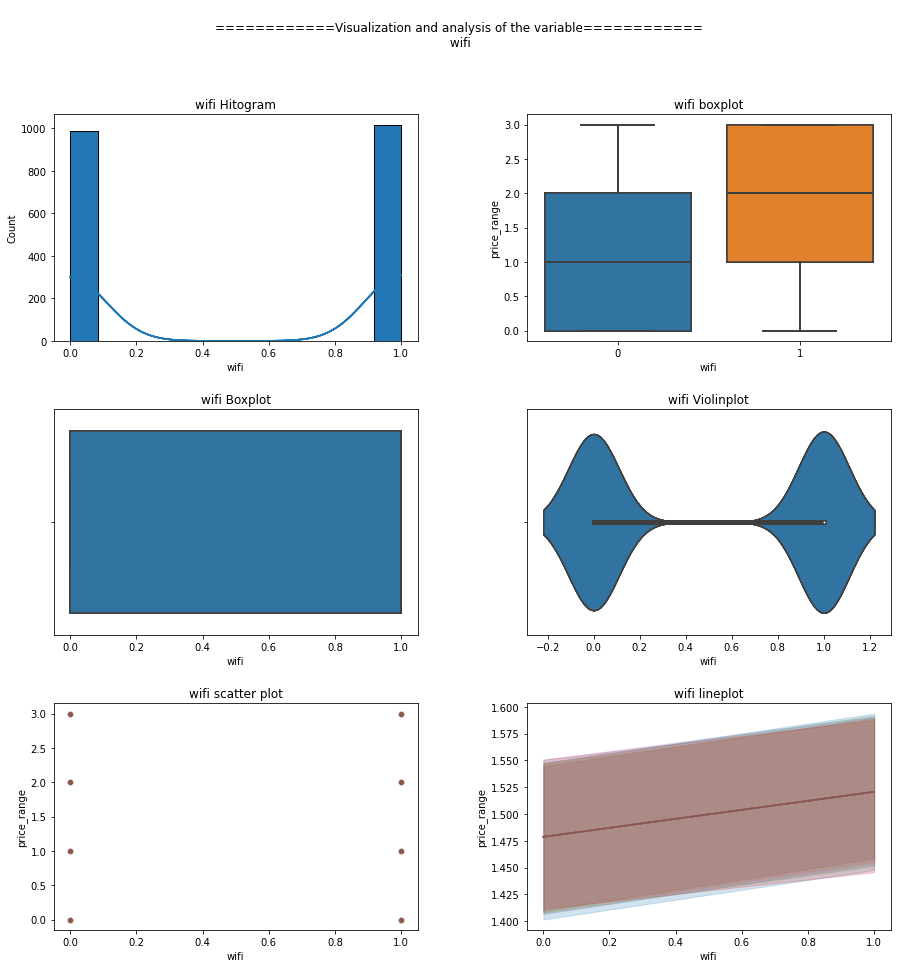

In [33]:
variable_visual(str(variable_to_visual[19]), 'price_range')

.

[]

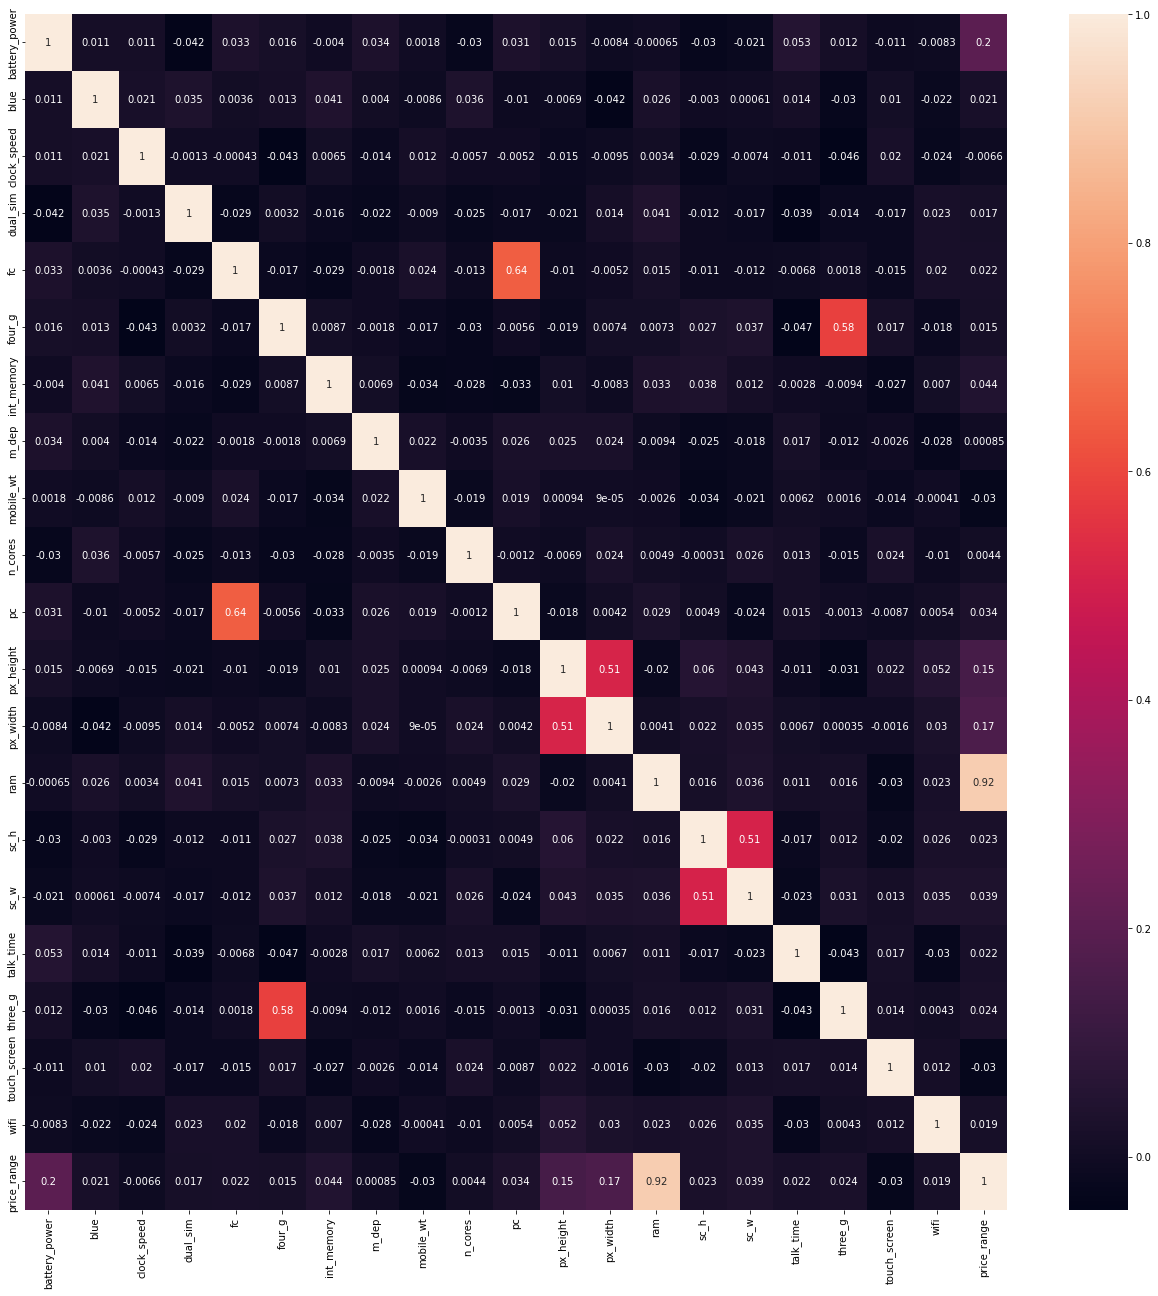

In [26]:
#display the correlation matrix to analyze the relationship between the variables

plt.figure(figsize=(22, 22))
sns.heatmap(dataset.corr(), annot=True)
plt.plot()

.

In [9]:
#
X = dataset.drop(['price_range'], axis=1)
y = dataset['price_range']

In [10]:
#split the data into test data and train data
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [24]:
#instantiate the models to use

models=[
    RandomForestClassifier(),
    AdaBoostClassifier(),
    lgb.LGBMClassifier(),
    SVC()   
]

In [27]:
# train the models

for model in models:
    model.fit(X_train,y_train)
    print('Model :', type(model).__name__)
    print('Score :',model.score(X_test,y_test))

Model : RandomForestClassifier
Score : 0.8875
Model : AdaBoostClassifier
Score : 0.57
Model : LGBMClassifier
Score : 0.9025
Model : SVC
Score : 0.965


.

SCV is the best model with default parameters, so we will look for the best parameters for SCV


In [29]:
cv = ShuffleSplit(n_splits=5,test_size=0.25,random_state=1234)

In [33]:
params={
    'C':np.arange(1,12,1),
    'kernel':['sigmoid', 'poly', 'rbf','linear']
}

In [34]:
SVC_serch_best_param=GridSearchCV(
    SVC(),
    param_grid=params,
    scoring='accuracy',
    cv=cv,
    verbose=10,
    return_train_score=True,

)

In [36]:
SVC_serch_best_param.fit(X_train,y_train)

Fitting 5 folds for each of 44 candidates, totalling 220 fits
[CV 1/5; 1/44] START C=1, kernel=sigmoid........................................
[CV 1/5; 1/44] END C=1, kernel=sigmoid;, score=(train=0.189, test=0.180) total time=   0.1s
[CV 2/5; 1/44] START C=1, kernel=sigmoid........................................
[CV 2/5; 1/44] END C=1, kernel=sigmoid;, score=(train=0.193, test=0.188) total time=   0.1s
[CV 3/5; 1/44] START C=1, kernel=sigmoid........................................
[CV 3/5; 1/44] END C=1, kernel=sigmoid;, score=(train=0.217, test=0.188) total time=   0.1s
[CV 4/5; 1/44] START C=1, kernel=sigmoid........................................
[CV 4/5; 1/44] END C=1, kernel=sigmoid;, score=(train=0.197, test=0.223) total time=   0.1s
[CV 5/5; 1/44] START C=1, kernel=sigmoid........................................
[CV 5/5; 1/44] END C=1, kernel=sigmoid;, score=(train=0.197, test=0.215) total time=   0.1s
[CV 1/5; 2/44] START C=1, kernel=poly....................................

[CV 5/5; 10/44] START C=3, kernel=poly..........................................
[CV 5/5; 10/44] END C=3, kernel=poly;, score=(train=0.966, test=0.965) total time=   0.0s
[CV 1/5; 11/44] START C=3, kernel=rbf...........................................
[CV 1/5; 11/44] END C=3, kernel=rbf;, score=(train=0.949, test=0.963) total time=   0.0s
[CV 2/5; 11/44] START C=3, kernel=rbf...........................................
[CV 2/5; 11/44] END C=3, kernel=rbf;, score=(train=0.961, test=0.948) total time=   0.0s
[CV 3/5; 11/44] START C=3, kernel=rbf...........................................
[CV 3/5; 11/44] END C=3, kernel=rbf;, score=(train=0.963, test=0.945) total time=   0.0s
[CV 4/5; 11/44] START C=3, kernel=rbf...........................................
[CV 4/5; 11/44] END C=3, kernel=rbf;, score=(train=0.955, test=0.970) total time=   0.2s
[CV 5/5; 11/44] START C=3, kernel=rbf...........................................
[CV 5/5; 11/44] END C=3, kernel=rbf;, score=(train=0.958, test=0.963

[CV 3/5; 20/44] END C=5, kernel=linear;, score=(train=0.986, test=0.968) total time=  33.0s
[CV 4/5; 20/44] START C=5, kernel=linear........................................
[CV 4/5; 20/44] END C=5, kernel=linear;, score=(train=0.988, test=0.975) total time=  14.7s
[CV 5/5; 20/44] START C=5, kernel=linear........................................
[CV 5/5; 20/44] END C=5, kernel=linear;, score=(train=0.987, test=0.973) total time=  27.9s
[CV 1/5; 21/44] START C=6, kernel=sigmoid.......................................
[CV 1/5; 21/44] END C=6, kernel=sigmoid;, score=(train=0.178, test=0.168) total time=   0.1s
[CV 2/5; 21/44] START C=6, kernel=sigmoid.......................................
[CV 2/5; 21/44] END C=6, kernel=sigmoid;, score=(train=0.181, test=0.170) total time=   0.1s
[CV 3/5; 21/44] START C=6, kernel=sigmoid.......................................
[CV 3/5; 21/44] END C=6, kernel=sigmoid;, score=(train=0.192, test=0.170) total time=   0.1s
[CV 4/5; 21/44] START C=6, kernel=sigmoi

[CV 4/5; 30/44] START C=8, kernel=poly..........................................
[CV 4/5; 30/44] END C=8, kernel=poly;, score=(train=0.967, test=0.970) total time=   0.0s
[CV 5/5; 30/44] START C=8, kernel=poly..........................................
[CV 5/5; 30/44] END C=8, kernel=poly;, score=(train=0.971, test=0.973) total time=   0.0s
[CV 1/5; 31/44] START C=8, kernel=rbf...........................................
[CV 1/5; 31/44] END C=8, kernel=rbf;, score=(train=0.960, test=0.965) total time=   0.0s
[CV 2/5; 31/44] START C=8, kernel=rbf...........................................
[CV 2/5; 31/44] END C=8, kernel=rbf;, score=(train=0.973, test=0.945) total time=   0.0s
[CV 3/5; 31/44] START C=8, kernel=rbf...........................................
[CV 3/5; 31/44] END C=8, kernel=rbf;, score=(train=0.963, test=0.948) total time=   0.0s
[CV 4/5; 31/44] START C=8, kernel=rbf...........................................
[CV 4/5; 31/44] END C=8, kernel=rbf;, score=(train=0.959, test=0.97

[CV 2/5; 40/44] END C=10, kernel=linear;, score=(train=0.987, test=0.963) total time=  37.2s
[CV 3/5; 40/44] START C=10, kernel=linear.......................................
[CV 3/5; 40/44] END C=10, kernel=linear;, score=(train=0.987, test=0.970) total time=  36.4s
[CV 4/5; 40/44] START C=10, kernel=linear.......................................
[CV 4/5; 40/44] END C=10, kernel=linear;, score=(train=0.988, test=0.975) total time=  19.4s
[CV 5/5; 40/44] START C=10, kernel=linear.......................................
[CV 5/5; 40/44] END C=10, kernel=linear;, score=(train=0.988, test=0.973) total time=  31.0s
[CV 1/5; 41/44] START C=11, kernel=sigmoid......................................
[CV 1/5; 41/44] END C=11, kernel=sigmoid;, score=(train=0.176, test=0.165) total time=   0.0s
[CV 2/5; 41/44] START C=11, kernel=sigmoid......................................
[CV 2/5; 41/44] END C=11, kernel=sigmoid;, score=(train=0.179, test=0.170) total time=   0.1s
[CV 3/5; 41/44] START C=11, kernel=

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1234, test_size=0.25, train_size=None),
             estimator=SVC(),
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'kernel': ['sigmoid', 'poly', 'rbf', 'linear']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [37]:
print(SVC_serch_best_param.best_params_)

{'C': 1, 'kernel': 'linear'}


In [59]:
print("best score :", SVC_serch_best_param.score(X_test, y_test))

best score : 0.97


.

In [45]:
y_pred = SVC_serch_best_param.predict(X_test)

[]

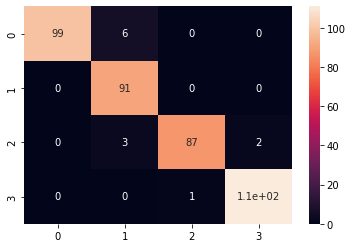

In [53]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.plot()

.

In [55]:
f1_score(y_test, y_pred, average='macro')

0.9692002874448208

.

Gickel OKABI ISSEKE